# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Autoencode](#classifier)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Pathways <a name="1pathways"></a>

In [77]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [78]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [79]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (3029950, 110)
Our input array Uy is of shape: (3035459, 110)
Printing a row of Ux: 
 [0.06417897 0.25470302 0.55885671 0.9493     1.38895813 1.83536662
 2.24512906 2.57829978 2.80235851 2.89542637 2.99010086 3.07846599
 3.16237576 3.24272178 3.31993687 3.39424293 3.46575844 3.53454851
 3.60064961 3.66408252 3.72485926 3.7829869  3.83846969 3.89131023
 3.94151015 3.98907053 4.03399206 4.07627523 4.11592037 4.15292772
 4.18729746 4.21902971 4.24812457 4.27458211 4.29840238 4.31958542
 4.33813127 4.35403995 4.36731148 4.37794586 4.38594311 4.39130324
 4.39402626 4.39450555 4.39404578 4.39284058 4.39093435 4.38834725
 4.38508917 4.38116522 4.37657817 4.37132956 4.36542029 4.35885087
 4.3516216  4.34373269 4.33518425 4.32597635 4.31610906 4.3055824
 4.29439639 4.28255106 4.27004643 4.25688248 4.24305925 4.22857672
 4.2134349  4.19763381 4.18117343 4.16405377 4.14627483 4.12783661
 4.10873912 4.08898235 4.06856631 4.04749099 4.02575639 4.00336252
 3.98030938 

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [80]:
size = Ux.shape[0]/25
print("We have run", Ux.shape[0],"simulations with a step of",size)

We have run 3029950 simulations with a step of 121198.0


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [81]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [82]:
ratio_pts = 0.1
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(302500, 110) (302500, 110)


In [83]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

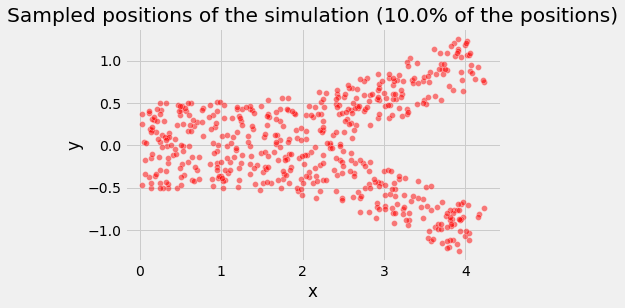

In [84]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a single matrix with dimensions $((2 N_u N_t), N_s)$

In [85]:
print(new_Ux)

[[0.05297715 0.2061886  0.44266392 ... 2.02004071 1.99099906 1.96151397]
 [0.01322163 0.04695252 0.09198472 ... 0.26373287 0.25978999 0.2557881 ]
 [0.04901893 0.19057232 0.40862265 ... 1.83301461 1.80660185 1.77978629]
 ...
 [0.06329908 0.25164429 0.55250989 ... 2.94060993 2.8988906  2.85652978]
 [0.01160936 0.03880894 0.07115106 ... 0.13202943 0.12995503 0.12785035]
 [0.02760381 0.10274274 0.21184031 ... 0.88227332 0.86956985 0.85667256]]


In [86]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(550, 121000)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [87]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

121000


## 3. Auto-encoder  <a name="autoencoder"></a>

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [88]:
# Set seed 
seed = 123
flattened_array_train, flattened_array_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = flattened_array_train, flattened_array_test

print(flattened_array_train.shape)
print(flattened_array_test.shape)

(495, 121000)
(55, 121000)


In [89]:
# define network parameters
learningRate=1e-2
epochs=50
input_size=flattened_array_train.shape[1]
k_folds = 5
# Set fixed random number seed
torch.manual_seed(42)

net = Autoencoder(input_size)
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate, weight_decay=1e-5)
# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

FOLD 0
--------------------------------
epoch : 1/50, loss = 11.777614
epoch : 2/50, loss = 11.829932
epoch : 3/50, loss = 11.806046
epoch : 4/50, loss = 11.728207
epoch : 5/50, loss = 11.599147
epoch : 6/50, loss = 11.438289
epoch : 7/50, loss = 11.282928
epoch : 8/50, loss = 10.968486
epoch : 9/50, loss = 10.119913
epoch : 10/50, loss = 11.167444
epoch : 11/50, loss = 9.005278
epoch : 12/50, loss = 8.973442
epoch : 13/50, loss = 8.946441
epoch : 14/50, loss = 8.940672
epoch : 15/50, loss = 8.927617
epoch : 16/50, loss = 8.898455
epoch : 17/50, loss = 9.690073
epoch : 18/50, loss = 8.157663
epoch : 19/50, loss = 8.641799
epoch : 20/50, loss = 5.684822
epoch : 21/50, loss = 7.059631
epoch : 22/50, loss = 8.019503
epoch : 23/50, loss = 8.834670
epoch : 24/50, loss = 9.237714
epoch : 25/50, loss = 11.682246
epoch : 26/50, loss = 11.577346
epoch : 27/50, loss = 11.108529
epoch : 28/50, loss = 4.889892
epoch : 29/50, loss = 3.711779
epoch : 30/50, loss = 3.267744
epoch : 31/50, loss = 3.33

epoch : 47/50, loss = 10.673260
epoch : 48/50, loss = 10.822606
epoch : 49/50, loss = 10.877980
epoch : 50/50, loss = 10.916448
{'train_loss': [0.5327784911508282], 'test_loss': [0.536513494459377]}
Performance of 5 fold cross validation
Average Training Loss: 0.532 	 Average Test Loss: 0.531


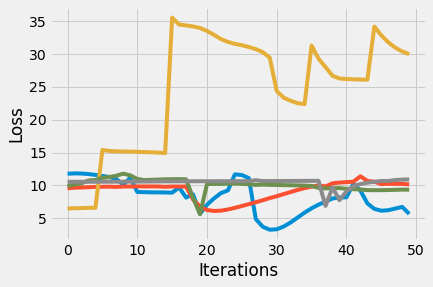

In [90]:
from crossvalidation import *
Kfold_2(flattened_array, k_folds, net, epochs, criterion, optimizer)

epoch : 1/20, loss = 89.976379
epoch : 2/20, loss = 89.117630
epoch : 3/20, loss = 88.207451
epoch : 4/20, loss = 87.249901
epoch : 5/20, loss = 86.244148
epoch : 6/20, loss = 85.189156
epoch : 7/20, loss = 84.085228
epoch : 8/20, loss = 82.935043
epoch : 9/20, loss = 81.741646
epoch : 10/20, loss = 80.509277
epoch : 11/20, loss = 79.240044
epoch : 12/20, loss = 77.939369
epoch : 13/20, loss = 76.614403
epoch : 14/20, loss = 75.272675
epoch : 15/20, loss = 73.917183
epoch : 16/20, loss = 72.556717
epoch : 17/20, loss = 71.198273
epoch : 18/20, loss = 69.846786
epoch : 19/20, loss = 68.506615
epoch : 20/20, loss = 67.184853


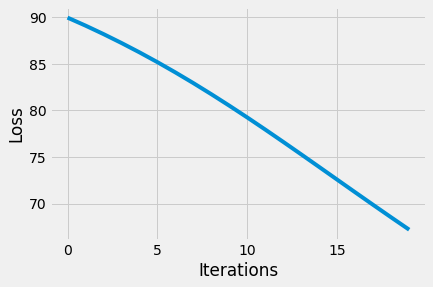

In [38]:
train(flattened_array_train, net, epochs, criterion, optimizer)

In [41]:
test(flattened_array_test, net, epochs, criterion, optimizer)

0.5143844414558748

In [42]:
test(flattened_array_train, net, epochs, criterion, optimizer)

0.6944974394473606

## 4. Passer en 2D 

## 5. Hyper-parameters and physics parameters relationship

## 6. Discussion & conclusion